# TOPIC MODELING

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
df1 = pd.read_csv("./listings_details.csv",low_memory=False)
df2 = pd.read_csv("./listings.csv")
df3 = pd.read_csv("./reviews_details.csv")
df4 = pd.read_csv("./neighbourhoods.csv")
df5 = gpd.read_file("./neighbourhoods.geojson")

These are the 5 dataset available to me. Form these 5 dataset the most relevant columns for topic modeling are those containing text data, such as  'description' ,  'summary' ,  'neighborhood_overview' ,  'notes' ,  'transit' ,  'access' ,  'interaction' ,     'house_rules' and 'comments' . 

 The potential wealth of information encapsulated in multiple columns. However, we opt to channel our focus towards a singular textual source: the 'comments' column of Dataset - 3("reviews_details").

In [3]:
review = df3.copy()

In [4]:
review.shape

(431830, 6)

row-431830

Columns - 6

In [5]:
# columns
print(review.columns)

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')


In [6]:
print(df3.dtypes)

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object


In [7]:
review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1,2818,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
2,2818,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
3,2818,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
4,2818,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


In [8]:
# taking a sample comment
review.comments.sample()

201330    What a nice experience, staying on a houseboat...
Name: comments, dtype: object

In [9]:
# or 

review['comments'][0]

'Daniel is really cool. The place was nice and clean. Very quiet neighborhood. He had maps and a lonely planet guide book in the room for you to use. I didnt have any trouble finding the place from Central Station. I would defintely come back! Thanks!'

from this comment above we can understand about the host experience, quiet neighbouhood, accessibility and direction.

Overall a positive experience

These are the basic topics that we can take.This is an outline of the topic modeling.This outline effectively sets the stage for conducting topic modeling on the comment data, guiding the analysis towards uncovering these thematic elements.

## preprocessing

--------------------------------

In [10]:
# checking null values

review.isnull().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         530
dtype: int64

In [11]:
# removing null values
review.dropna(subset=['comments'], inplace=True)

In [12]:
review.comments.isnull().sum()

0

In [13]:
review.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

In [14]:
# aggregating the comment with respect to listing_id

review_agg = review.groupby('listing_id')['comments'].apply(lambda x : ' '.join(x)).reset_index()

In [15]:
review_agg.head()

,listing_id,comments
0,2818,Daniel is really cool. The place was nice and ...
1,3209,"Lovely Appartment over 2 levels, lots of space..."
2,20168,The location of Sasha's B&B makes it ideal for...
3,25428,The apartment was spacious clean and perfectly...
4,27886,"Excellent accommodation, close to everything, ..."


In [16]:
review_agg['comments'][0]

'Daniel is really cool. The place was nice and clean. Very quiet neighborhood. He had maps and a lonely planet guide book in the room for you to use. I didnt have any trouble finding the place from Central Station. I would defintely come back! Thanks! Daniel is the most amazing host! His place is extremely clean, and he provides everything you could possibly want (comfy bed, guidebooks & maps, mini-fridge, towels, even toiletries). He is extremely friendly and helpful, and will go out of his way to help you if needed, or just let you come and go as you please. Highly recommended! We had such a great time in Amsterdam. Daniel is an excellent host! Very friendly and everytime helpful. The room was cozy, comfortable, and VERY clean. Maps, towels, mini-fridge, coffee (very tasty) and tea supplies were provided. Bathroom with all the bathroom requires. Good location - next to the tram stop and it took just around 10-15 minutes to get to the city center.\r\nTotally recommendable!  Very profe

# Data Cleaning and Preprocessing:

In [17]:
print(review_agg['comments'].dtype)


object


#### remove punctuation and changing to lower case

In [18]:
import re

# Define a function to process each comment
def process_comment(comment):
    # Remove punctuation
    comment = re.sub('[,.!?]', '', comment)
    # Convert to lowercase
    comment = comment.lower()
    return comment

# Preprocess comments for the 'comments' column
review_agg['comment_processed'] = review_agg['comments'].apply(process_comment)


In [19]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = review_agg.comment_processed.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])

['daniel', 'is', 'really', 'cool', 'the', 'place', 'was', 'nice', 'and', 'clean', 'very', 'quiet', 'neighborhood', 'he', 'had', 'maps', 'and', 'lonely', 'planet', 'guide', 'book', 'in', 'the', 'room', 'for', 'you', 'to', 'use', 'didnt', 'have']


## removing stopwords and lemmetizing the data

In [20]:
import nltk
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def rem_stop_words(text):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in text]


# def make_bigram(text):
#     return[bigram_mod[doc] for doc in text]

# def make_trigram(text):
#     return[trigram_mod[doc] for doc in text]

def lemmatation(text, allowed_postags= ['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in text:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
    




In [21]:
import spacy

data_words_nonstops = rem_stop_words(data_words)

# data_words_bigrams = make_bigram(data_words_nonstops)

# data_words_trigrams = make_trigram(data_words_bigrams)

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# lemmetization
data_lemmatization = lemmatation(data_words_nonstops,allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatization[:1][0][:30])


['really', 'cool', 'place', 'nice', 'clean', 'quiet', 'neighborhood', 'map', 'lonely', 'planet', 'guide', 'book', 'room', 'trouble', 'find', 'place', 'central', 'station', 'defintely', 'come', 'back', 'thank', 'daniel', 'amazing', 'host', 'place', 'extremely', 'clean', 'provide', 'possibly']


# EDA

----------------------------------------------

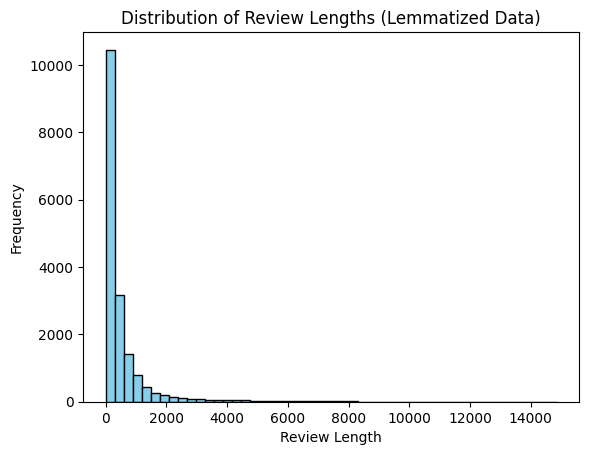

In [22]:
# Visualize the distribution of review lengths using lemmatized data
review_lengths_lemmatized = [len(review) for review in data_lemmatization]
plt.hist(review_lengths_lemmatized, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths (Lemmatized Data)')
plt.show()


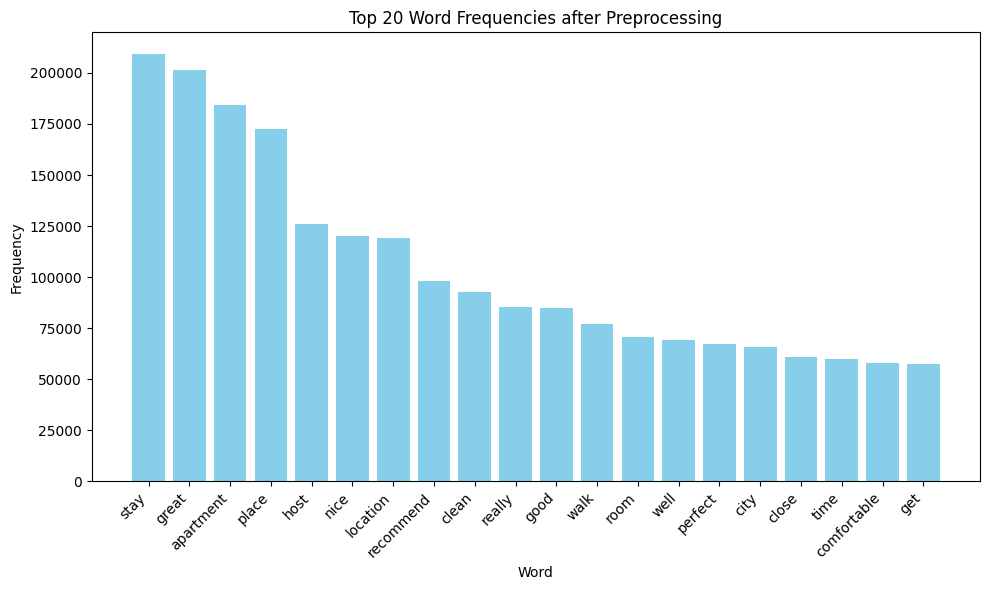

In [23]:
from collections import Counter
import matplotlib.pyplot as plt

# Calculate word frequencies after preprocessing
word_counts = Counter(word for review in data_lemmatization for word in review)

# Create a DataFrame for word frequencies
word_freq_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Frequency'])

# Sort the DataFrame by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

# Visualize the top 20 word frequencies
plt.figure(figsize=(10, 6))
plt.bar(word_freq_df['Word'][:20], word_freq_df['Frequency'][:20], color='skyblue')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Top 20 Word Frequencies after Preprocessing')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [24]:
# Number of documents
num_documents = len(data_lemmatization)

# Average document length
avg_doc_length = sum(len(doc) for doc in data_lemmatization) / num_documents

# Vocabulary size
vocabulary_size = len(set(word for doc in data_lemmatization for word in doc))

print("Number of Documents:", num_documents)
print("Average Document Length:", avg_doc_length)
print("Vocabulary Size:", vocabulary_size)


Number of Documents: 17621
Average Document Length: 533.6427558027353
Vocabulary Size: 87361


In [25]:
missing_documents = review_agg['comments'].isnull().sum()
print("Missing Documents:", missing_documents)

# Examine the distribution of word frequencies
word_freq_df = pd.DataFrame(list(word_counts.items()), columns=['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)
print("Top 10 Words by Frequency:")
print(word_freq_df.head(10))

Missing Documents: 0
Top 10 Words by Frequency:
          Word  Frequency
75        stay     209425
45       great     201426
139  apartment     184083
2        place     172392
23        host     126120
3         nice     119971
58    location     119036
44   recommend      97945
4        clean      92651
0       really      85152


## creating corpus

In [26]:
import gensim.corpora as corpora

# create dictonary
id2word = corpora.Dictionary(data_lemmatization)

# create corpus
texts = data_lemmatization

# term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:30])

[(0, 6), (1, 1), (2, 12), (3, 1), (4, 1), (5, 2), (6, 12), (7, 5), (8, 1), (9, 1), (10, 1), (11, 11), (12, 2), (13, 6), (14, 2), (15, 4), (16, 1), (17, 2), (18, 1), (19, 1), (20, 3), (21, 1), (22, 1), (23, 3), (24, 1), (25, 1), (26, 4), (27, 1), (28, 1), (29, 1)]


# Model Building

In [27]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,num_topics=10,
                                      random_state=100,
                                      chunksize=100,
                                      passes=10,
                                      per_word_topics=True)

In [28]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"und" + 0.022*"die" + 0.014*"stay" + 0.012*"un" + 0.012*"place" + '
  '0.010*"alle" + 0.010*"nice" + 0.009*"city" + 0.008*"great" + 0.008*"man"'),
 (1,
  '0.027*"nice" + 0.026*"apartment" + 0.025*"place" + 0.024*"stay" + '
  '0.020*"great" + 0.017*"really" + 0.016*"clean" + 0.015*"host" + '
  '0.014*"good" + 0.013*"city"'),
 (2,
  '0.027*"location" + 0.023*"apartment" + 0.023*"great" + 0.016*"stay" + '
  '0.014*"place" + 0.010*"good" + 0.010*"walk" + 0.009*"nice" + 0.008*"clean" '
  '+ 0.007*"check"'),
 (3,
  '0.035*"apartment" + 0.031*"great" + 0.027*"stay" + 0.021*"place" + '
  '0.018*"location" + 0.015*"host" + 0.014*"recommend" + 0.012*"walk" + '
  '0.011*"perfect" + 0.011*"well"'),
 (4,
  '0.041*"room" + 0.028*"place" + 0.027*"stay" + 0.024*"great" + 0.024*"host" '
  '+ 0.017*"clean" + 0.017*"location" + 0.016*"nice" + 0.013*"good" + '
  '0.012*"recommend"'),
 (5,
  '0.038*"tre" + 0.025*"nous" + 0.022*"appartement" + 0.016*"host" + '
  '0.015*"apartment" + 0.015*"et"

In [29]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os 

num_topics = 10

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+str(num_topics))

if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

C:\Users\amalv\anaconda3\jupyter\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.132046  0.001264       1        1  29.442241
1     -0.128886  0.002409       2        1  17.903981
2     -0.109800 -0.007427       3        1  13.254243
4     -0.108274  0.011205       4        1  12.784385
5     -0.087182 -0.015231       5        1   8.572770
9     -0.082880  0.009996       6        1   6.980707
0     -0.065803 -0.009341       7        1   6.290856
7     -0.077217 -0.010394       8        1   4.392046
6      0.372073  0.175209       9        1   0.198071
8      0.420016 -0.157690      10        1   0.180701, topic_info=            Term           Freq          Total Category  logprob  loglift
1165        room   70414.000000   70414.000000  Default  30.0000  30.0000
1417         tre   43182.000000   43182.000000  Default  29.0000  29.0000
86     apartment  182410.000000  182410.000000  Default  28.0000  28.0000
2235        boat   14734.000000   14734.000000  Default  27.0000  27.0000
910         nous   26298.000000   26298.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
10297      andre     309.734676     321.802880  Topic10  -4.0048   6.2779
22592     steven     105.165569     108.336850  Topic10  -5.0850   6.2864
10347       lily     142.158891     160.647631  Topic10  -4.7835   6.1938
817         mark     630.026895     973.281189  Topic10  -3.2947   5.8812
11848  warehouse      59.546484     109.067522  Topic10  -5.6537   5.7109

[810 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
8985      7  0.003822  aart
8985      8  0.993666  aart
24        1  0.103437    ad
24        2  0.091315    ad
24        3  0.092931    ad
...     ...       ...   ...
1527      4  0.058531    zu
1527      5  0.000434    zu
1527      6  0.023846    zu
1527      7  0.890544    zu
1527      8  0.016475    zu

[2818 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 6, 10, 1, 8, 7, 9])

## Finding the coherence score

In [30]:
from gensim.models import CoherenceModel

# compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatization, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'coherence score :  {coherence_lda:.4f}')

coherence score :  0.4027


# LDA after leguage detection

In [33]:
import nltk
from langdetect import detect
import gensim.corpora as corpora

# Assuming you have performed lemmatization and stored the result in data_lemmatization
# Join the lemmatized words into complete sentences or texts
complete_documents = [' '.join(document) for document in data_lemmatization]

english_text_data = []

for document in complete_documents:
    try:
        # Detect the language of the document
        lang = detect(document)
        # Check if the detected language is English
        if lang == 'en':
            english_text_data.append(document)
    except:
        # Handle any exceptions that might occur during language detection
        pass

# Now english_text_data contains only the English documents from the lemmatized data

# Tokenize each document into words
tokenized_documents = [document.split() for document in english_text_data]

# create dictionary
id2word = corpora.Dictionary(tokenized_documents)

# create corpus
texts = tokenized_documents

# term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:30])


[(0, 6), (1, 1), (2, 12), (3, 1), (4, 1), (5, 2), (6, 12), (7, 5), (8, 1), (9, 1), (10, 1), (11, 11), (12, 2), (13, 6), (14, 2), (15, 4), (16, 1), (17, 2), (18, 1), (19, 1), (20, 3), (21, 1), (22, 1), (23, 3), (24, 1), (25, 1), (26, 4), (27, 1), (28, 1), (29, 1)]


In [34]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,num_topics=10,
                                      random_state=100,
                                      chunksize=100,
                                      passes=10,
                                      per_word_topics=True)

In [35]:
from pprint import pprint

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"und" + 0.019*"die" + 0.013*"stay" + 0.011*"place" + 0.011*"un" + '
  '0.010*"nice" + 0.009*"tre" + 0.009*"alle" + 0.009*"great" + 0.008*"minute"'),
 (1,
  '0.026*"stay" + 0.021*"place" + 0.021*"host" + 0.014*"nice" + 0.014*"great" '
  '+ 0.013*"home" + 0.013*"really" + 0.012*"recommend" + 0.011*"make" + '
  '0.011*"room"'),
 (2,
  '0.041*"breakfast" + 0.023*"stay" + 0.015*"host" + 0.013*"make" + '
  '0.013*"place" + 0.012*"great" + 0.011*"morning" + 0.010*"provide" + '
  '0.010*"recommend" + 0.009*"wonderful"'),
 (3,
  '0.034*"boat" + 0.028*"stay" + 0.019*"great" + 0.016*"houseboat" + '
  '0.014*"experience" + 0.013*"place" + 0.011*"location" + 0.010*"host" + '
  '0.009*"recommend" + 0.008*"perfect"'),
 (4,
  '0.035*"apartment" + 0.025*"stay" + 0.025*"great" + 0.025*"place" + '
  '0.024*"nice" + 0.016*"clean" + 0.015*"really" + 0.015*"recommend" + '
  '0.013*"host" + 0.012*"city"'),
 (5,
  '0.034*"room" + 0.025*"place" + 0.024*"great" + 0.023*"location" + '
  '0.023*"sta

In [36]:
def compute_coherence_value(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                          id2word=id2word,
                                          num_topics = k,
                                          random_state=100,
                                          passes = 10,
                                          alpha = a,
                                          eta= b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=english_word_data, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [37]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os 

num_topics = 10

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

C:\Users\amalv\anaconda3\jupyter\lib\site-packages\pandas\core\dtypes\cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.097661  0.001539       1        1  31.467646
4     -0.094324  0.025600       2        1  19.517129
5     -0.077035 -0.005817       3        1  15.471611
1     -0.074986 -0.019632       4        1  11.137275
0     -0.050802 -0.059140       5        1   7.241720
8     -0.064201 -0.016916       6        1   6.372344
3     -0.057227 -0.045223       7        1   4.633004
2     -0.032295 -0.066999       8        1   3.046808
6      0.100003  0.263646       9        1   0.944361
9      0.448529 -0.077058      10        1   0.168102, topic_info=            Term           Freq          Total Category  logprob  loglift
655         host  130161.000000  130161.000000  Default  30.0000  30.0000
342          day   40335.000000   40335.000000  Default  29.0000  29.0000
86     apartment  183032.000000  183032.000000  Default  28.0000  28.0000
106      arrival   19139.000000   19139.000000  Default  27.0000  27.0000
1417         tre   43937.000000   43937.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
13673      lance      62.804564      79.280527  Topic10  -5.5250   6.1554
2742       elena      52.589216      63.776151  Topic10  -5.7025   6.1955
3496          ed      73.946487     139.840907  Topic10  -5.3617   5.7512
13691    mathieu      46.675237      53.303752  Topic10  -5.8218   6.2556
2112      studio      47.264608    9290.968910  Topic10  -5.8093   1.1073

[807 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
8971       7  0.996625      aart
56636      1  0.989950   adriaan
13466      2  0.055164      agne
13466      3  0.942805      agne
44         1  0.012943  agreable
...      ...       ...       ...
1527       3  0.059377        zu
1527       4  0.014514        zu
1527       5  0.882302        zu
1527       7  0.028589        zu
1527       8  0.009236        zu

[2623 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 6, 2, 1, 9, 4, 3, 7, 10])

In [38]:
from gensim.models import CoherenceModel

# compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'coherence score :  {coherence_lda:.4f}')

coherence score :  0.3691


-------------------------------------------------------------------

# hyper parameter tuning

### Grid search

In [ ]:
import numpy as np
import tqdm
import os 

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_value(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    os.makedirs('./results/', exist_ok=True)
    pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
    pbar.close()



In [ ]:
result_df = pd.read_csv("./results/lda_tuning_results.csv")
result_df.head()

## visualisation of hyper parameters

In [ ]:
import matplotlib.pyplot as plt

# Filter the DataFrame for a specific validation set (e.g., '75% Corpus')
validation_set = '75% Corpus'
filtered_df = result_df[result_df['Validation_Set'] == validation_set]

# Group the filtered DataFrame by 'Alpha' and calculate the mean coherence score for each alpha value
grouped_df = filtered_df.groupby('Alpha')['Coherence'].mean().reset_index()

# Sort the DataFrame by 'Alpha' for plotting
grouped_df.sort_values(by='Alpha', inplace=True)

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(grouped_df['Alpha'], grouped_df['Coherence'], marker='o', linestyle='-')
plt.xlabel('Alpha')
plt.ylabel('Coherence Score (C_v)')
plt.title(f'Coherence Score vs. Alpha ({validation_set})')
plt.grid(True)
plt.show()


In [ ]:
data = result_df[['Topics', 'Coherence']]

# Aggregate data by averaging coherence scores for each number of topics
aggregated_data = data.groupby('Topics').mean().reset_index()

# Sort data by number of topics
aggregated_data = aggregated_data.sort_values(by='Topics')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(aggregated_data['Topics'], aggregated_data['Coherence'], marker='o', linestyle='-')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (C_v)')
plt.title('Coherence Score for Different Numbers of Topics')
plt.grid(True)
plt.show()

In [ ]:
# Filter data for K=8
data_k8 = result_df[result_df['Topics'] == 10]

# Find row with maximum coherence score for K=8
max_row_k8 = data_k8.loc[data_k8['Coherence'].idxmax()]

# Extract optimal alpha and beta parameters
optimal_alpha = max_row_k8['Alpha']
optimal_beta = max_row_k8['Beta']

print("Optimal Alpha:", optimal_alpha)
print("Optimal Beta:", optimal_beta)


In [ ]:
# Filter data for K=8
data_k8 = result_df[result_df['Topics'] == 10]

# Find row with maximum coherence score for K=8
max_row_k10 = data_k10.loc[data_k10['Coherence'].idxmax()]

# Sort filtered DataFrame by coherence score in descending order
sorted_data_k8 = data_k8.sort_values(by='Coherence', ascending=False)

# Select columns Beta, Alpha, Coherence, and Topics
selected_columns = sorted_data_k10[['Beta', 'Alpha', 'Coherence', 'Topics']]

# Optionally reset the index
selected_columns = selected_columns.reset_index(drop=True)

print(selected_columns.head())


In [ ]:
num_topics = 10

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           eta='symmetric')

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os 

num_topics = 10

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared